In [1]:
#### Saliency notebook
#### Takes an image and visualizes its saliency prediction

import os
import sys
import io
import time

import torch
import torchvision
import torch.nn.functional as nnF
import torchvision.transforms.functional as F
import numpy as np
import pandas as pd
from PIL import Image

def preprocess_img(img, i, j, h, w):
    # i, j, h, w = 0, 0, 7.0/8 * 512, 14.0/8 * 512
    img = F.crop(img, i, j, h, w)
    #img = F.resize(img, 256, torchvision.transforms.InterpolationMode.BICUBIC)
    img = F.to_tensor(img)
    return img

def normalize_imagenet(img):
    img = F.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    return img

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

img = Image.open('example_images/gnochi_mirror.jpeg')
print(img.size)
img_tensor = preprocess_img(img, 0, 0, img.size[1], img.size[0]).unsqueeze(0).to(DEVICE)
print(img_tensor.shape)


(960, 1280)
torch.Size([1, 3, 1280, 960])


In [2]:
# Load VGG and extract features for perceptual loss
from utils import hook_model

def load_vgg():
    vgg = torchvision.models.vgg16(pretrained=True)
    vgg.eval()
    vgg.to(DEVICE)
    return vgg

# load the pretrained VGG
vgg_model = load_vgg()

# Hook the model to reach its middle layers
vgg_hook, vgg_layers = hook_model(vgg_model, True)

# Forward pass to activate the hook
_ = vgg_model(normalize_imagenet(img_tensor))

# Choose a layer from vgg_layers.keys()
f_layer = 'features-30:MaxPool2d'

# Extract the features
feats = vgg_hook(f_layer).float()
print(feats.shape)


/home/aydemir/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aydemir/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 512, 40, 30])


In [30]:
############PREDICT SALIENCY###################
import matplotlib.pyplot as plt

device = "cuda"
img = Image.open('example_images/gnochi_mirror.jpeg')
print(img.size)

img_tensor = preprocess_img(img, 0, 0, img.size[1], img.size[0]).unsqueeze(0).to(DEVICE)
print(img_tensor.shape)
print("PNAS Model")
from saliency_backbone import PNAS
from collections import OrderedDict

from saliency_backbone.SimpleNet.model import PNASModel
from saliency_backbone.SimpleNet.dataloader import TestLoader
#from saliency_backbone.SimpleNet.model import PNASModel
model = PNASModel()
model_path = "/sinergia/bahar/visual-int/visintproject/prompt-to-prompt/saliency_backbone/salicon_pnas.pt"
#model.load_state_dict(torch.load())
state_dict = torch.load(model_path)
new_state_dict = OrderedDict()
for k, v in state_dict.items():
            if 'module'  in k:
                k = k.replace('module.', '', )
            new_state_dict[k] = v

model.load_state_dict(new_state_dict)


model = model.to(device)
val_img_dir = "/sinergia/bahar/visual-int/visintproject/prompt-to-prompt/example_images"
val_img_ids = os.listdir()
val_dataset = TestLoader(val_img_dir, val_img_ids)
#vis_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=args.no_workers)


(960, 1280)
torch.Size([1, 3, 1280, 960])
PNAS Model
AAAAA
96 96 54
96 270 108
270 540 216
540 1080 216
1080 1080 216
1080 1080 216
1080 1080 432
1080 2160 432
2160 2160 432
2160 2160 432
2160 2160 864
2160 4320 864
4320 4320 864
4320 4320 864


In [31]:
img_input = normalize_imagenet(img_tensor)
out = model(img_input)
print(out.shape)

torch.Size([1, 1280, 960])


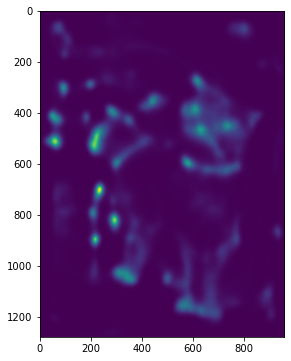

In [32]:
img_array = out.cpu().detach().permute(1, 2, 0).numpy()

# Create a figure and display the image
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(img_array)


# Show the figure
plt.show()